# 1 - IMPORTING LIBRARIES AND DATA

In [4]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
# !python -m spacy download it_core_news_sm
# !python -m spacy download pt_core_news_sm
# !python -m spacy download es_core_news_sm
# !python -m spacy download fr_core_news_sm
# !python -m spacy download ca_core_news_sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import spacy
import re
from deep_translator import GoogleTranslator
import time
from IPython.display import clear_output
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertModel, MarianMTModel, MarianTokenizer
from sentence_transformers import SentenceTransformer
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pickle
from google.cloud import translate_v2 as translate

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import gensim.downloader as api

nltk.download('stopwords')
nltk.download('punkt')
tqdm.pandas()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diogoparreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diogoparreira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df_train = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
df_train_reviews = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train_reviews.xlsx")



# 2 - EXPLORATORY DATA ANALYSIS 

In [6]:
df_train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [7]:
df_train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [8]:
# taking 10 comments per index to reduce the size of the dataset
df_train_reviews_10 = df_train_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)

In [9]:
max_index = df_train_reviews_10["index"].max()

print(max_index)

6248


In [10]:
# making sure that all indexes have 10 comments. Some indexes were missing or had less than 10 
def ensure_ten_comments_per_index(df, max_index):
    # Create an empty DataFrame to store the results
    result_df = pd.DataFrame(columns=df.columns)

    for idx in range(1, max_index + 1):
        # Filter the comments for the current index
        comments = df[df['index'] == idx]

        # If there are fewer than 10 comments, add empty strings
        if len(comments) < 10:
            missing_count = 10 - len(comments)
            empty_comments = pd.DataFrame({'index': [idx] * missing_count, 'comments': [''] * missing_count})
            comments = pd.concat([comments, empty_comments], ignore_index=True)

        result_df = pd.concat([result_df, comments], ignore_index=True)

    return result_df

# Apply the function to df_train_reviews
df_sampled = ensure_ten_comments_per_index(df_train_reviews_10, max_index)

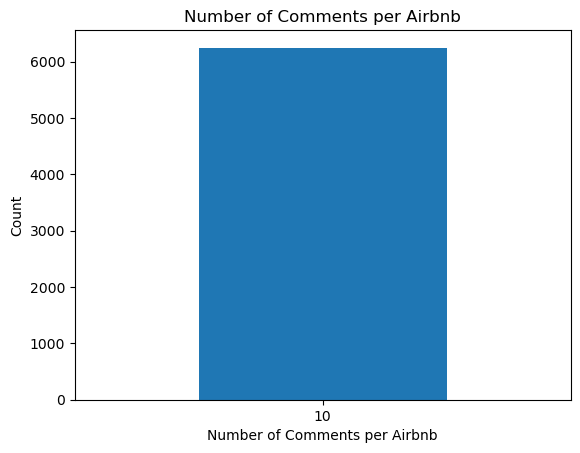

In [11]:
df_sampled['index'].value_counts().value_counts().sort_index().plot(kind='bar')
plt.title('Number of Comments per Airbnb')
plt.xlabel('Number of Comments per Airbnb')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()

In [12]:
df_sampled.head()

,index,comments
0,1,Very Nice.
1,1,top
2,1,"Un lugar muy acogedor, buen lugar donde hosped..."
3,1,The property is absolutely clean and stylish. ...
4,1,"Everything is correct, like the photos said. B..."


In [13]:
# Changing the df to have an index (listing of airbnb) per row and the comments as columns
def pivot_comments(df):
    # Add a new column 'comment_num' to enumerate comments for each index
    df['comment_num'] = df.groupby('index').cumcount() + 1

    # Pivot the dataframe to create the desired format
    df_pivoted = df.pivot_table(index='index', columns='comment_num', values='comments', aggfunc='first')

    # Rename the columns to 'comment1', 'comment2', ..., 'comment10'
    df_pivoted.columns = [f'comment {i}' for i in range(1, 11)]

    # Reset the index to make 'index' a regular column
    df_pivoted.reset_index(inplace=True)

    return df_pivoted

# Call the function with your dataframe
df_pivoted = pivot_comments(df_sampled)

In [14]:
df_pivoted.head()

,index,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,1,Very Nice.,top,"Un lugar muy acogedor, buen lugar donde hosped...",The property is absolutely clean and stylish. ...,"Everything is correct, like the photos said. B...",Personnes très agréable et très attentionné po...,You have to be there,Minha estadia foi quando estava comecando o su...,Great location and very good communication,Beside to big street and park.<br/>You can fin...
1,2,,,,,,,,,,
2,3,,,,,,,,,,
3,4,,,,,,,,,,
4,5,Vista fabulosa.<br/>Bom apartamento. <br/>Loca...,"Schöne Aussicht, sehr sauber, tolle Lage .",Lovely apartment with great views of the beach...,"Spectacular location, awsome place",Mein Freund und ich waren Im August eine Woche...,Clean Appartement with a very nice oceanview. ...,todo correcto. la casa está perfecta y limpia....,Clean and calm place. Perfect location - beach...,"Un super séjour,<br/>appartement conforme et c...",We really enjoyed staying at Sonias place. The...


In [15]:
#merge the description, host_about with the comments and unlisted
df_train = pd.merge(df_train, df_pivoted, on='index', how='left')
df_train.head()


,index,description,host_about,unlisted,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Very Nice.,top,"Un lugar muy acogedor, buen lugar donde hosped...",The property is absolutely clean and stylish. ...,"Everything is correct, like the photos said. B...",Personnes très agréable et très attentionné po...,You have to be there,Minha estadia foi quando estava comecando o su...,Great location and very good communication,Beside to big street and park.<br/>You can fin...
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,,,,,,,,,,
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,,,,,,,,,,
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,,,,,,,,,,
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Vista fabulosa.<br/>Bom apartamento. <br/>Loca...,"Schöne Aussicht, sehr sauber, tolle Lage .",Lovely apartment with great views of the beach...,"Spectacular location, awsome place",Mein Freund und ich waren Im August eine Woche...,Clean Appartement with a very nice oceanview. ...,todo correcto. la casa está perfecta y limpia....,Clean and calm place. Perfect location - beach...,"Un super séjour,<br/>appartement conforme et c...",We really enjoyed staying at Sonias place. The...


In [16]:
# #same for test now
# df_test_reviews_10 = df_test_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)
# max_index_test = df_test_reviews["index"].max()
# df_sampled_test = ensure_ten_comments_per_index(df_test_reviews_10, max_index_test)
# df_pivoted_test = pivot_comments(df_sampled_test)
# df_test = pd.merge(df_test, df_pivoted_test, on='index', how='left')
# df_test.head()

In [17]:
# Save the dataframes as CSV files to the specified directory
# df_train.to_csv("/Users/diogoparreira/Downloads/Project Corpora/train.csv", index=False)
# df_test.to_csv("/Users/diogoparreira/Downloads/Project Corpora/test.csv", index=False)


In [18]:
#import the above csv files
#df_train = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/train.csv")
#df_test = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/test.csv")


In [19]:
# Exploration

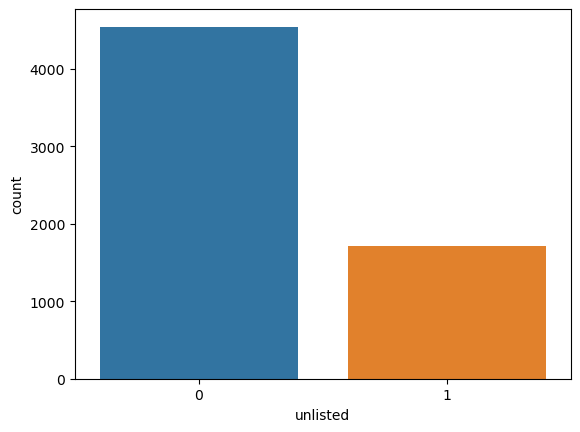

In [20]:
sns.countplot(x='unlisted', data=df_train)
plt.show()

In [21]:
# It is a bit imbalanced

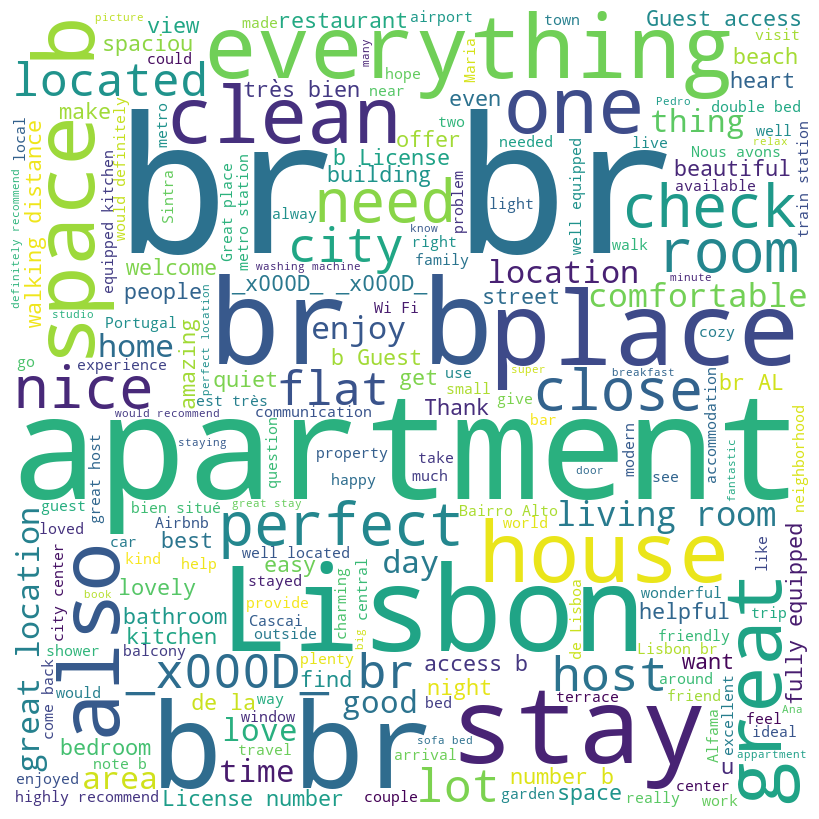

In [22]:
# word cloud for all of the df 
def create_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(stopwords.words('english')), 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

# Create a single string with all comments, description, and host_about
text = ' '.join(df_train['description'].fillna('') + ' ' + df_train['host_about'].fillna('') + ' ' + df_train['comment 1'].fillna('') + ' ' + df_train['comment 2'].fillna('') + ' ' + df_train['comment 3'].fillna('') + ' ' + df_train['comment 4'].fillna('') + ' ' + df_train['comment 5'].fillna('') + ' ' + df_train['comment 6'].fillna('') + ' ' + df_train['comment 7'].fillna('') + ' ' + df_train['comment 8'].fillna('') + ' ' + df_train['comment 9'].fillna('') + ' ' + df_train['comment 10'].fillna(''))

create_wordcloud(text)



In [23]:
# using code from the class to clean the text 
def clean_text(text):
    # Convert integers to strings
    if isinstance(text, int):
        text = str(text)
    # Check if the text resembles HTML markup
    if '<' in text:
        # Remove HTML tags
        clean_text = BeautifulSoup(text, "html.parser").get_text()
    else:
        # Remove special characters and punctuation
        clean_text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return clean_text

def clean_dataframe(df):
    # Apply text cleaning function to all columns except 'index'
    for col in df.columns:
        if col != 'index':
            df[col] = df[col].apply(clean_text)
    return df

# Clean df_train and df_test dataframes
df_train = clean_dataframe(df_train)
#df_test = clean_dataframe(df_test)

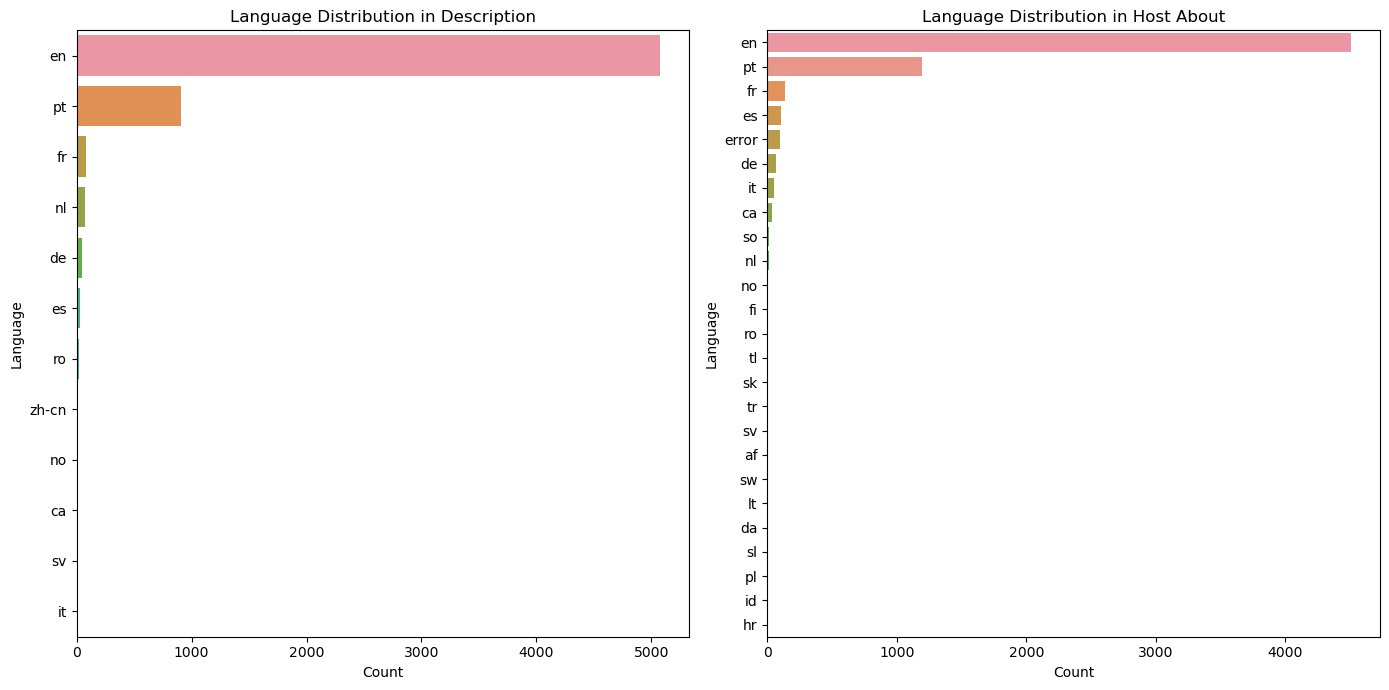

In [24]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'error'

df_train['lang_description'] = df_train['description'].apply(detect_language)
df_train['lang_host_about'] = df_train['host_about'].apply(detect_language)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(y='lang_description', data=df_train, order = df_train['lang_description'].value_counts().index)
plt.title('Language Distribution in Description')
plt.xlabel('Count')
plt.ylabel('Language')

plt.subplot(1, 2, 2)
sns.countplot(y='lang_host_about', data=df_train, order = df_train['lang_host_about'].value_counts().index)
plt.title('Language Distribution in Host About')
plt.xlabel('Count')
plt.ylabel('Language')

plt.tight_layout()
plt.show()

In [25]:
# checking for rows where language of description and host_about don't match
mismatch_mask = df_train['lang_description'] != df_train['lang_host_about']
percentage_mismatch = (mismatch_mask.sum() / len(df_train)) * 100
percentage_mismatch

23.655569782330346

In [26]:
#make a copy of the dataframe
df_train_copy = df_train.copy()


# 3 - EMBEDDINGS

## 3.1 - BERTDISTIL to embed everything wihitout translating

In [41]:
# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

def get_distilbert_embedding(text):
    if not text.strip():
        # Return a predefined vector for empty strings
        return np.zeros(model.config.hidden_size)
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Forward pass through DistilBERT model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embeddings from DistilBERT's output
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze(0)
    return embeddings.numpy()

In [19]:

# Embed all descriptions
descriptions = df_train['description'].astype(str).tolist()
description_embeddings = []

# Embed descriptions with progress bar
for desc in tqdm(descriptions, desc="Embedding descriptions"):
    description_embeddings.append(get_distilbert_embedding(desc))

df_train['description_embedding'] = description_embeddings


Embedding descriptions:   0%|          | 0/6248 [00:00<?, ?it/s]

In [20]:
# Get host abouts and convert to list of strings
host_abouts = df_train['host_about'].astype(str).tolist()

# Embed host abouts with progress bar
host_about_embeddings = []
for host_about in tqdm(host_abouts, desc="Embedding host abouts"):
    host_about_embeddings.append(get_distilbert_embedding(host_about))

# Assign host about embeddings to DataFrame
df_train['host_about_embedding'] = host_about_embeddings



Embedding host abouts:   0%|          | 0/6248 [00:00<?, ?it/s]

In [21]:
print(df_train.head())
# Check length of embeddings for the first few rows
for i in range(5):
    print(f"Embedding length for row {i+1}: {len(df_train['host_about_embedding'][i])}")


   index                                        description  \
0      1  This is a shared mixed room in our hostel with...   
1      2  O meu espao fica perto de Parque Eduardo VII S...   
2      3  Trafarias House is a cozy and familiar villa w...   
3      4  Apartamento Charmoso no Chiado Entre o Largo d...   
4      5  Joli appartement  en bordure de mer 2 min a pi...   

                                          host_about unlisted  \
0                  Alojamento Local Registro 20835AL        0   
1  I am friendly host and I will try to always be...        1   
2  I am a social person liking to communicate rea...        1   
3  Hellox000D\nI m Portuguese and i love to meet ...        0   
4  Nous sommes une famille avec deux enfants de 1...        0   

                                           comment 1  \
0                                          Very Nice   
1                                                      
2                                                      
3     

In [42]:
# Embed all comments
comments_columns = ['comment 1', 'comment 2', 'comment 3', 'comment 4', 'comment 5', 
                    'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

# Initialize a dictionary to hold embeddings for each comment column
comments_embeddings = {col: [] for col in comments_columns}

In [22]:


# Embed each comment column separately with progress bar
for col in comments_columns:
    comments = df_train[col].tolist()
    for comment in tqdm(comments, desc=f"Embedding {col}"):
        if isinstance(comment, str):
            comments_embeddings[col].append(get_distilbert_embedding(comment))
        else:
            # Use a zero vector if the comment is not a string (e.g., NaN)
            comments_embeddings[col].append(np.zeros(768))

# Add embeddings back to the dataframe
for col in comments_columns:
    df_train[f'{col}_embedding'] = comments_embeddings[col]

Embedding comment 1:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 2:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 3:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 4:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 5:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 6:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 7:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 8:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 9:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 10:   0%|          | 0/6248 [00:00<?, ?it/s]

In [23]:
# #do the same for test
# # Embed all descriptions
# descriptions = df_test['description'].astype(str).tolist()
# description_embeddings = []

# # Embed descriptions with progress bar
# for desc in tqdm(descriptions, desc="Embedding descriptions"):
#     description_embeddings.append(get_distilbert_embedding(desc))

# df_test['description_embedding'] = description_embeddings

# # Get host abouts and convert to list of strings
# host_abouts = df_test['host_about'].astype(str).tolist()

# # Embed host abouts with progress bar
# host_about_embeddings = []
# for host_about in tqdm(host_abouts, desc="Embedding host abouts"):
#     host_about_embeddings.append(get_distilbert_embedding(host_about))

# # Assign host about embeddings to DataFrame
# df_test['host_about_embedding'] = host_about_embeddings

# # Embed all comments
# comments_columns = ['comment 1', 'comment 2', 'comment 3', 'comment 4', 'comment 5', 
#                     'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

# # Initialize a dictionary to hold embeddings for each comment column
# comments_embeddings = {col: [] for col in comments_columns}

# # Embed each comment column separately with progress bar
# for col in comments_columns:
#     comments = df_test[col].tolist()
#     for comment in tqdm(comments, desc=f"Embedding {col}"):
#         if isinstance(comment, str):
#             comments_embeddings[col].append(get_distilbert_embedding(comment))
#         else:
#             # Use a zero vector if the comment is not a string (e.g., NaN)
#             comments_embeddings[col].append(np.zeros(768))

# # Add embeddings back to the dataframe
# for col in comments_columns:
#     df_test[f'{col}_embedding'] = comments_embeddings[col]



In [24]:
#divide the train into train and validation
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)


In [25]:
# lets use the embedings to predict the unlisted column 
# Define the features and target variable. The features should be the embeddings
X_train = df_train[['description_embedding', 'host_about_embedding', 
                    'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                    'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                    'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                    'comment 10_embedding']]
X_val = df_val[['description_embedding', 'host_about_embedding',
                'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                'comment 10_embedding']]

y_train = df_train['unlisted']
y_val = df_val['unlisted']

# # Convert the embeddings to numpy arrays
# X_train = np.array(X_train.values.tolist())
# X_val = np.array(X_val.values.tolist())


In [26]:
X_train.shape

(4998, 12)

In [27]:
#look at the first value of the description_embedding
X_train['description_embedding'][0]

array([-2.85978168e-01, -2.56181091e-01,  2.04515249e-01, -2.79023796e-02,
        1.98387668e-01,  2.35756263e-02, -3.28062713e-01,  1.71490878e-01,
       -2.11339593e-01, -2.82241926e-02,  9.38400701e-02,  2.00517222e-01,
        8.39001298e-01,  3.44331086e-01,  1.06219716e-01, -3.91563267e-01,
        4.02772903e-01, -4.47052598e-01,  4.19721127e-01,  2.89283663e-01,
        2.83775330e-01,  2.04233795e-01,  2.25758582e-01, -1.14375390e-01,
        2.54416466e-01, -1.22701444e-01, -4.99133021e-01,  9.57736894e-02,
       -3.99195738e-02, -2.33291671e-01,  1.12832509e-01,  5.72889507e-01,
       -2.45490268e-01,  8.17805767e-01,  5.25217019e-02,  2.99819201e-01,
        1.84777379e-01,  2.96739787e-01, -1.12581670e-01, -1.86522394e-01,
       -2.90778596e-02,  3.63248438e-01,  2.86400408e-01, -2.04956725e-01,
        3.45782667e-01, -2.23039120e-01,  4.52955246e-01,  1.77736714e-01,
       -1.52998000e-01, -2.85406530e-01,  7.13064820e-02, -2.95515656e-01,
        6.76545620e-01,  

In [28]:
y_train

1738    0
142     1
2638    0
3407    1
5650    0
       ..
3772    0
5191    1
5226    0
5390    0
860     1
Name: unlisted, Length: 4998, dtype: object

In [29]:
X_train.head()

,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
1738,"[-0.20470436, -0.23839971, 0.303345, 0.1398042...","[-0.04256296, -0.15366057, -0.120283484, 0.395...","[0.09037343, -0.20292337, 0.1431247, 0.1589535...","[-0.1787788, -0.35959342, -0.04760647, 0.02264...","[0.040639155, -0.29456124, 0.28896725, 0.42972...","[-0.090141065, -0.53219813, 0.3240194, 0.46815...","[0.104196586, -0.18798164, 0.44960222, 0.31420...","[-0.18548732, -0.3183362, -0.295636, 0.2092443...","[0.03437853, -0.18645819, -0.0070517757, 0.212...","[-0.27099264, -0.523219, 0.29767436, 0.0444691...","[0.003647952, -0.32476208, 0.5379392, 0.313290...","[-0.16650839, -0.28550646, 0.36706597, 0.14799..."
142,"[0.055727407, -0.16742255, 0.35076088, 0.33966...","[-0.22538137, -0.40542316, -0.07076159, -0.146...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
2638,"[-0.18655038, -0.22335035, 0.20210643, 0.01560...","[-0.22883394, -0.0008261181, 0.10724445, -0.05...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
3407,"[-0.29429653, -0.2608666, 0.08344908, -0.08472...","[0.2201043, -0.11754492, 0.25464883, 0.1068565...","[-0.104928866, -0.5147655, 0.11046683, 0.02960...","[0.045188297, -0.37775227, -0.3434282, 0.41255...","[-0.17907572, -0.44759983, 0.2629546, -0.04663...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
5650,"[-0.45134586, -0.3250975, 0.21362151, -0.04061...","[0.1488951, -0.07589937, 0.35994726, 0.1156875...","[-0.12555537, -0.16222171, -0.075729534, 0.051...","[0.1788513, -0.08927859, 0.0065753856, 0.14931...","[-0.03907493, -0.32141218, 0.30669302, 0.16930...","[0.056224275, -0.19399175, 0.039945003, 0.2145...","[-0.029564092, -0.087317124, 0.055836074, 0.06...","[0.040635925, -0.2041511, -0.048759967, -0.035...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."


In [30]:

X_train.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
X_val.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")


In [48]:
def flatten_row(row):
    return np.concatenate(row.values)

X_train_flattened = X_train.apply(flatten_row, axis=1)
X_val_flattened = X_val.apply(flatten_row, axis=1)

X_train = np.vstack(X_train_flattened.values)
X_val = np.vstack(X_val_flattened.values)



In [49]:

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("X_train type:", type(X_train))
print("X_val type:", type(X_val))
print("y_train type:", type(y_train))
print("y_val type:", type(y_val))


X_train shape: (4998, 9216)
X_val shape: (1250, 9216)
y_train shape: (4998,)
y_val shape: (1250,)
X_train type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
y_val type: <class 'numpy.ndarray'>


In [50]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

### 3.1.1 - Making predictions - always using the same models - rf, knn and simple feed forward neural network

In [35]:
rf = RandomForestClassifier(random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Average cross-validation score on training data: ", np.mean(cv_scores))

# Train the model on the full training set
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)



Average cross-validation score on training data:  0.8907593593593595
Validation accuracy:  0.8904


In [36]:


# Define the model with some chosen hyperparameters
knn = KNeighborsClassifier(n_neighbors=5)

# Perform 5-fold cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the average accuracy across all folds
print("Average cross-validation score: ", np.mean(scores))

knn.fit(X_train, y_train)

val_predictions = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)





/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Average cross-validation score:  0.8683507507507509
Validation accuracy:  0.8816


Training fold 1...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.7337 - loss: 2.4384 - val_accuracy: 0.8520 - val_loss: 0.4050
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.7785 - loss: 0.6292 - val_accuracy: 0.8410 - val_loss: 0.4318
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8246 - loss: 0.4989 - val_accuracy: 0.8650 - val_loss: 0.3961
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.8007 - loss: 0.5111 - val_accuracy: 0.8560 - val_loss: 0.4441
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.8215 - loss: 0.4624 - val_accuracy: 0.8690 - val_loss: 0.3937
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.8279 - loss: 0.4110 - val_accuracy: 0.8690 - val_loss: 0.3787
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.8371 - loss: 0.4363 - val_accuracy: 0.8660 - val_loss: 0.3777
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.8296 - loss: 0.4148 -

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6964 - loss: 2.6286 - val_accuracy: 0.7210 - val_loss: 0.4332
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7213 - loss: 1.0559 - val_accuracy: 0.8360 - val_loss: 0.3870
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.7395 - loss: 0.6194 - val_accuracy: 0.7140 - val_loss: 0.4279
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7069 - loss: 0.5416 - val_accuracy: 0.7140 - val_loss: 0.4348
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.7292 - loss: 0.4580 - val_accuracy: 0.7140 - val_loss: 0.4114
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.7846 - loss: 0.4487 - val_accuracy: 0.8610 - val_loss: 0.3995
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.8246 - loss: 0.4438 - val_accuracy: 0.8620 - val_loss: 0.3960
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8352 - loss: 0.4183

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.7317 - loss: 2.8589 - val_accuracy: 0.8420 - val_loss: 0.4595
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.7257 - loss: 0.7475 - val_accuracy: 0.8150 - val_loss: 0.4281
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7173 - loss: 0.5859 - val_accuracy: 0.7320 - val_loss: 0.4253
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7026 - loss: 0.5440 - val_accuracy: 0.7320 - val_loss: 0.4598
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.7152 - loss: 0.5144 - val_accuracy: 0.7320 - val_loss: 0.4360
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.7297 - loss: 0.5018 - val_accuracy: 0.7320 - val_loss: 0.4373
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.7280 - loss: 0.5086 - val_accuracy: 0.7320 - val_loss: 0.4258
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.7288 - loss: 0.4398 - va

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.7438 - loss: 2.6442 - val_accuracy: 0.8509 - val_loss: 0.4258
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7587 - loss: 0.7038 - val_accuracy: 0.8458 - val_loss: 0.4260
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.6958 - loss: 0.6885 - val_accuracy: 0.8458 - val_loss: 0.4021
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7231 - loss: 0.5932 - val_accuracy: 0.7427 - val_loss: 0.4078
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.7122 - loss: 0.5476 - val_accuracy: 0.7427 - val_loss: 0.4246
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.7158 - loss: 0.5273 - val_accuracy: 0.7427 - val_loss: 0.3864
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7247 - loss: 0.4876 - val_accuracy: 0.7427 - val_loss: 0.4333
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7222 - loss: 0.461

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.7530 - loss: 2.5773 - val_accuracy: 0.8058 - val_loss: 0.4528
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.7373 - loss: 0.7829 - val_accuracy: 0.8308 - val_loss: 0.4443
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.7771 - loss: 0.5430 - val_accuracy: 0.8268 - val_loss: 0.4638
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.7740 - loss: 0.5023 - val_accuracy: 0.8168 - val_loss: 0.4465
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.7470 - loss: 0.5032 - val_accuracy: 0.8088 - val_loss: 0.4290
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8177 - loss: 0.4492 - val_accuracy: 0.8358 - val_loss: 0.4471
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7935 - loss: 0.4430 - val_accuracy: 0.8458 - val_loss: 0.4089
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.8102 - loss: 0.4344 -

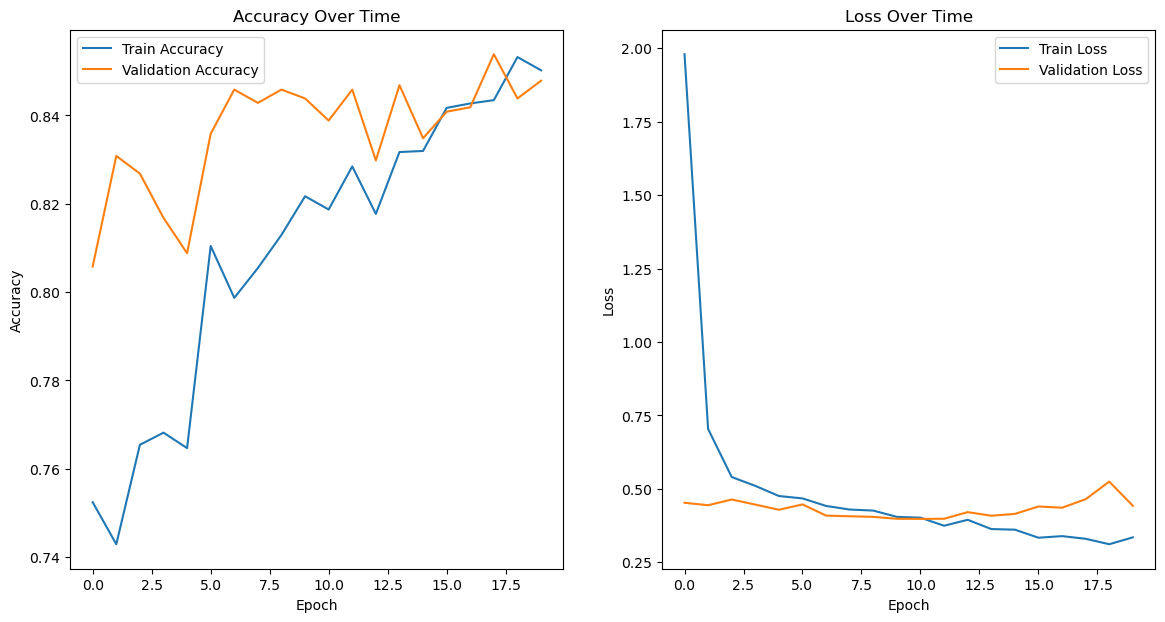

In [41]:
X = np.array(X_train) 
y = np.array(y_train) 

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
accuracy_per_fold = []
loss_per_fold = []

def create_model(input_shape):
    model = Sequential([
        Dense(1000, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'), 
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    # Split data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Create and train the model
    model = create_model(X_train_fold.shape[1])
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, batch_size=32, verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

# Plot the results
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

# Training history plotting for the last fold (as an example)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.show()



### 3.1.2 - Do we need all the 10 comments or can we just average them? ###

In [51]:
def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

X_train = np.apply_along_axis(average_and_reduce, 1, X_train)
X_val = np.apply_along_axis(average_and_reduce, 1, X_val)

# Verify the shapes
print("X_train_reduced shape:", X_train.shape) 
print("X_val_reduced shape:", X_val.shape) 



X_train_reduced shape: (4998, 2304)
X_val_reduced shape: (1250, 2304)


In [55]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Average cross-validation score on training data: ", np.mean(cv_scores))

# Train the model on the full training set
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Average cross-validation score on training data:  0.8921589589589589
Validation accuracy:  0.8936


In [56]:
confusion_matrix(y_val, val_predictions)


array([[823,  82],
       [ 51, 294]])

In [58]:
# some extra false negatives but nothing dramatic I'd say 
# lets see if we can improve it by oversampling the unlisted class 
# Oversample the unlisted class

oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)

X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after resampling
unique, counts = np.unique(y_train_resampled, return_counts=True)
dict(zip(unique, counts))

cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Average cross-validation score on training data: ", np.mean(cv_scores))

# Train the model on the resampled training set
rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the validation set
val_predictions = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy after oversampling: ", val_accuracy)

#confusion matrix of the best model
confusion_matrix(y_val, val_predictions)


Average cross-validation score on training data:  0.9104957155711031
Validation accuracy after oversampling:  0.8944


array([[824,  81],
       [ 51, 294]])

In [278]:
# mostly no difference

In [53]:
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the average accuracy across all folds
print("Average cross-validation score: ", np.mean(scores))

knn.fit(X_train, y_train)

val_predictions = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)


Average cross-validation score:  0.8603445445445445
Validation accuracy:  0.8584


Training fold 1...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7462 - loss: 0.9330 - val_accuracy: 0.8350 - val_loss: 0.4183
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7739 - loss: 0.5176 - val_accuracy: 0.7760 - val_loss: 0.4265
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7889 - loss: 0.5120 - val_accuracy: 0.8370 - val_loss: 0.4115
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8159 - loss: 0.4554 - val_accuracy: 0.8280 - val_loss: 0.4075
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8114 - loss: 0.4394 - val_accuracy: 0.8360 - val_loss: 0.4205
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8130 - loss: 0.4364 - val_accuracy: 0.8460 - val_loss: 0.3875
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8208 - loss: 0.4233 - val_accuracy: 0.8380 - val_loss: 0.3915
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8227 - loss: 0.4054 - val_accuracy: 0.844

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7363 - loss: 1.0365 - val_accuracy: 0.7580 - val_loss: 0.4270
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7155 - loss: 0.5245 - val_accuracy: 0.7150 - val_loss: 0.4293
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7065 - loss: 0.5102 - val_accuracy: 0.8350 - val_loss: 0.4168
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7840 - loss: 0.4633 - val_accuracy: 0.8270 - val_loss: 0.4250
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8079 - loss: 0.4444 - val_accuracy: 0.8360 - val_loss: 0.4106
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8083 - loss: 0.4401 - val_accuracy: 0.8250 - val_loss: 0.4224
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8158 - loss: 0.4423 - val_accuracy: 0.8400 - val_loss: 0.4108
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8264 - loss: 0.4215 - val_accuracy: 0.829

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7141 - loss: 0.9517 - val_accuracy: 0.8220 - val_loss: 0.4000
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7492 - loss: 0.5278 - val_accuracy: 0.8130 - val_loss: 0.4016
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8018 - loss: 0.5218 - val_accuracy: 0.8120 - val_loss: 0.4284
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8118 - loss: 0.4404 - val_accuracy: 0.8130 - val_loss: 0.3987
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8165 - loss: 0.4363 - val_accuracy: 0.8140 - val_loss: 0.4100
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8285 - loss: 0.4222 - val_accuracy: 0.8030 - val_loss: 0.4118
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8046 - loss: 0.4401 - val_accuracy: 0.8070 - val_loss: 0.3929
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8244 - loss: 0.4175 - val_accuracy: 0.811

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7370 - loss: 0.8759 - val_accuracy: 0.8348 - val_loss: 0.4153
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7659 - loss: 0.5213 - val_accuracy: 0.8408 - val_loss: 0.3794
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7874 - loss: 0.5084 - val_accuracy: 0.8529 - val_loss: 0.3780
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8077 - loss: 0.4858 - val_accuracy: 0.8448 - val_loss: 0.3876
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8058 - loss: 0.4599 - val_accuracy: 0.8509 - val_loss: 0.4030
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8141 - loss: 0.4354 - val_accuracy: 0.8438 - val_loss: 0.3826
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8254 - loss: 0.4174 - val_accuracy: 0.8418 - val_loss: 0.3990
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8129 - loss: 0.4358 - val_accuracy: 0.851

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7515 - loss: 0.8825 - val_accuracy: 0.8068 - val_loss: 0.4234
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7717 - loss: 0.5575 - val_accuracy: 0.8148 - val_loss: 0.4251
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7914 - loss: 0.4705 - val_accuracy: 0.8168 - val_loss: 0.4166
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8040 - loss: 0.4499 - val_accuracy: 0.8168 - val_loss: 0.4009
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8185 - loss: 0.3978 - val_accuracy: 0.8308 - val_loss: 0.4091
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8057 - loss: 0.4310 - val_accuracy: 0.8118 - val_loss: 0.4085
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7939 - loss: 0.4151 - val_accuracy: 0.8268 - val_loss: 0.3939
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8137 - loss: 0.3999 - val_accuracy: 0.828

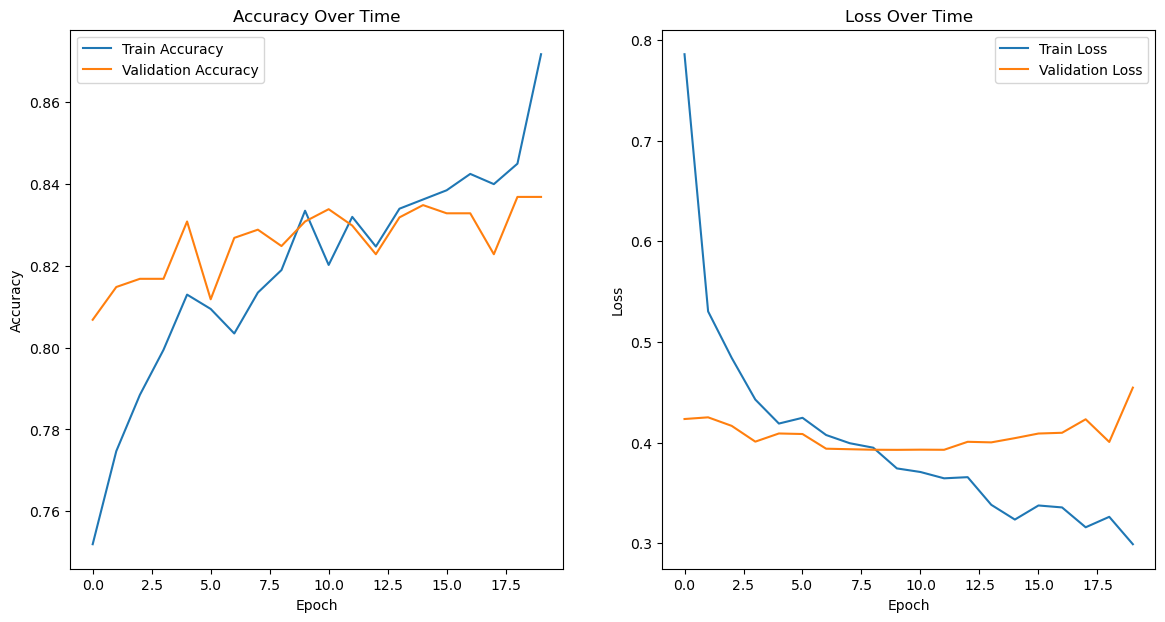

In [54]:
X = np.array(X_train) 
y = np.array(y_train)  

fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    # Split data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Create and train the model
    model = create_model(X_train_fold.shape[1])
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, batch_size=32, verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

# Plot the results
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

# Training history plotting for the last fold
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.show()

## 3.2 - Translating eveything to EN and using different embedding techniques

In [95]:
#lets get a copy of the df_train 
df_train = df_train_copy.copy()

In [96]:
df_train.head()

,index,description,host_about,unlisted,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,lang_description,lang_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro 20835AL,0,Very Nice,top,Un lugar muy acogedor buen lugar donde hospeda...,The property is absolutely clean and stylish I...,"Everything is correct, like the photos said. B...",Personnes trs agrable et trs attentionn pour n...,You have to be there,Minha estadia foi quando estava comecando o su...,Great location and very good communication,Beside to big street and park.You can find the...,en,pt
1,2,O meu espao fica perto de Parque Eduardo VII S...,I am friendly host and I will try to always be...,1,,,,,,,,,,,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,I am a social person liking to communicate rea...,1,,,,,,,,,,,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hellox000D\nI m Portuguese and i love to meet ...,0,,,,,,,,,,,pt,en
4,5,Joli appartement en bordure de mer. 2 min. a ...,Nous sommes une famille avec deux enfants de 1...,0,Vista fabulosa.Bom apartamento. Localização fa...,Schne Aussicht sehr sauber tolle Lage,Lovely apartment with great views of the beach...,Spectacular location awsome place,Mein Freund und ich waren Im August eine Woche...,Clean Appartement with a very nice oceanview H...,todo correcto la casa est perfecta y limpia la...,Clean and calm place Perfect location beach g...,"Un super séjour,appartement conforme et confor...",We really enjoyed staying at Sonias place The ...,fr,fr


In [98]:
# Set Google Cloud credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/diogoparreira/Downloads/idyllic-silo-423522-f5-d45c376d14ed.json"

# Initialize Google Translate client
translate_client = translate.Client()

# Define the target language
target_language = 'en'

# Columns to translate
columns_to_translate = ['description', 'host_about', 'comment 1', 'comment 2', 'comment 3',
                        'comment 4', 'comment 5', 'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

# Function to translate text using Google Translate API
def translate_text(text):
    translation = translate_client.translate(text, target_language=target_language)
    return translation['translatedText']

# Translate each column and create new DataFrame with translated columns
translated_columns = {}
for col in tqdm(columns_to_translate):
    translated_columns[col] = df_train[col].apply(lambda x: translate_text(x))

# Create DataFrame with translated columns
df_train_translated = pd.DataFrame(translated_columns)

# Save the translated DataFrame to the specified directory
output_file_path = "/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv"
df_train_translated.to_csv(output_file_path, index=False)

print(f"Translated DataFrame saved to: {output_file_path}")


100%|██████████| 12/12 [1:24:15<00:00, 421.28s/it]


Translated DataFrame saved to: /Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv


In [175]:
df_train_translated

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration 20835AL,Very Nice,top,"A very cozy place, good place to stay, very cl...",The property is absolutely clean and stylish I...,"Everything is correct, like the photos said. B...",Very pleasant people and very attentive to our...,You have to be there,My stay was when the Corona outbreak was start...,Great location and very good communication,Beside to big street and park.You can find the...
1,My space is close to Parque Eduardo VII Saldan...,I am friendly host and I will try to always be...,,,,,,,,,,
2,Trafaria’s House is a cozy and familiar villa ...,I am a social person liking to communicate rea...,,,,,,,,,,
3,"Charming Apartment in Chiado, Between Largo do...",Hellox000D\nI m Portuguese and i love to meet ...,,,,,,,,,,
4,Nice apartment by the sea. 2 min. walk to the ...,We are a family with two children aged 17 and ...,Fabulous view. Nice apartment. Fantastic locat...,Nice view very clean great location,Lovely apartment with great views of the beach...,Spectacular location awsome place,My boyfriend and I stayed with Sonia for a wee...,Clean Appartement with a very nice oceanview H...,"Everything is correct, the house is perfect an...",Clean and calm place Perfect location beach g...,"A great stay, apartment compliant and comforta...",We really enjoyed staying at Sonias place The ...
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"Studio 15 is a new, very well decorated and co...",Im a Brand Manager from Lisbon in Portugal but...,"Superb studio, very clean and super well equip...",We really enjoyed our stay The host location ...,Perfectly adapted and well-equipped accommodat...,"Vasco and his wife are wonderful people, we mi...","Vasco always responded very quickly, gave us l...",We had a great time in Vascos appartment every...,The host was super supportive and very nice gu...,My parents had a great stay at Studio15 in Lis...,Vasco and Anna were amazing hosts They picked...,"Excellent host, kind, fast and friendly. Very ..."
6244,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors How do we ...,This a spacious apartment in the heart of Barr...,This place is great Modern clean flat right in...,Air conditioning would have been welcome! The ...,Be careful a little cold in winter Great view ...,Apartment very well located and well isolated ...,Very good stay in Bairro Alto the apartment is...,Awesome hosts perfect communication nice flat ...,The apartment was very nice we enjoyed it,Great place to stay in Lisbon for a few days C...,I had a really good time in this flat!_x000D_T...
6245,License numberExempt,I am a travel agent passionate by cultures \nI...,Location location location If beach vibes a lo...,"The Apartment is very pleasant, as mentioned i...",Do not recommend. Host extremely hard to commu...,Just the best stay in Estoril! Sara is a great...,Excellent stay at Saras Everything is thorough...,Good location and Sara very attentive at all t...,We spent two days in Estoril with stormy coast...,Saras place is as described and even though it...,The location is at the back of what appears to...,Sara is a great host. She was always attentive...
6246,Campo Pequeno Prestige is a classy and top qua...,Familyx000D Portugalx000D Gaviox000D musicx000...,We couldn&#39;t enjoy the stay due to a proble...,I had a comfortable and easy stay here for fou...,Maria is an amazing host the entire place is s...,It’s nice and spacious room near the entrecomp...,another great stay my second with Maria conven...,Clean great location great shopping comfortable,"Great place, close to two subway stations, bak...","Excellent stay, impeccable facilities and very...",We had a very good time in the apartment. You ...,Close to metro The place is very clean and tid...


In [318]:
#using the code from the class to clean the text

stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()
        
        # Decode HTML entities
        text = re.sub(r'&[a-zA-Z]+;', ' ', text)
        
        # LOWERCASE TEXT
        text = text.lower()
        
        # REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]", " ", text)
        
        # REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        # Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())
    
    return text



In [177]:
df_train = df_train_translated.applymap(clean_text)

/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_52991/1781868646.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train = df_train_translated.applymap(clean_text)
/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_52991/1843448870.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [180]:
df_train_w2v = df_train.copy()

## 3.2.1 - Word2Vec

In [182]:
w2v = gensim.downloader.load('word2vec-google-news-300')

emb_size = 300

#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

def df_corpus2vec(df):
    df_vec = pd.DataFrame(index=df.index, columns=df.columns)
    for col in df.columns:
        df_vec[col] = corpus2vec(df[col].tolist())
    return df_vec

# Apply the function to the DataFrame
df_train_vec = df_corpus2vec(df_train_w2v)


  0%|          | 0/6248 [00:01<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

In [183]:
#save the df to a pickle file
df_train_vec.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_train_vec.pkl")


In [124]:
# import the df_train_vec
df_train_vec = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_train_vec.pkl")



In [125]:
df_train_vec

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...",[],"[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125..."
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...",[],[],[],[],[],[],[],[],[],[]
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...",[],[],[],[],[],[],[],[],[],[]
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...",[],[],[],[],[],[],[],[],[],[]
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[[0.15332031, -0.005004883, -0.22753906, 0.010...","[[-0.036621094, 0.014526367, 0.03515625, 0.230...","[[0.060791016, 0.14746094, -0.11376953, -0.068...","[[0.096191406, -0.028686523, -0.10839844, 0.14...","[[-0.057861328, -0.21777344, -0.1484375, 0.166...","[[0.03930664, -0.19628906, -0.10644531, -0.026...","[[0.055908203, 0.057617188, 0.015197754, 0.251...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[-0.12158203, 0.234375, 0.1484375, -0.0197753...","[[-0.11376953, -0.33398438, -0.029541016, 0.07...","[[-0.036132812, -0.11230469, 0.022827148, 0.22...","[[-0.21289062, -0.0043029785, -0.18066406, -0...."
6244,"[[-0.07910156, -0.0046691895, 0.02746582, 0.05...","[[-0.01184082, 0.079589844, 0.016845703, -0.08...","[[-0.018798828, 0.18554688, -0.06225586, -0.11...","[[-0.20703125, 0.203125, 0.041992188, -0.11572...","[[0.036376953, 0.10498047, 0.13769531, -0.1542...","[[0.44140625, 0.16699219, -0.029663086, 0.3261...","[[0.203125, -0.29101562, -0.12207031, -0.01135...","[[0.040527344, 0.0625, -0.017456055, 0.0786132...","[[0.07470703, -0.09033203, -0.055908203, 0.120...","[[0.203125, -0.29101562, -0.12207031, -0.01135...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14..."
6245,"[[-0.07861328, -0.46484375, 0.1640625, -0.3281...","[[0.17578125, 0.21289062, -0.07128906, 0.08496...","[[0.032714844, -0.096191406, 0.044189453, 0.17...","[[0.203125, -0.29101562, -0.12207031, -0.01135...","[[-0.17480469, -0.13183594, 0.15429688, 0.1826...","[[-0.12695312, 0.021972656, 0.28710938, 0.1533...","[[-0.21289062, -0.0043029785, -0.18066406, -0....","[[0.040527344, 0.0625, -0.017456055, 0.0786132...","[[0.25390625, 0.16113281, 0.033203125, 0.12304...","[[-0.20703125, 0.203125, 0.041992188, -0.11572...","[[0.032714844, -0.096191406, 0.044189453, 0.17...","[[-0.014709473, 0.10986328, 0.029052734, 0.332..."
6246,"[[0.15820312, 0.09326172, 0.075683594, 0.16308...","[[0.19042969, 0.09716797, -0.26757812, -0.0620...","[[-0.0012588501, -0.048339844, -0.28320312, 0....","[[-0.006958008, 0.047607422, -0.2890625, 0.025...","[[-0.26171875, -0.114746094, 0.16992188, 0.102...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.194

In [126]:
# getting the unlisted column back to then split the data into train and validation
df_train_vec = pd.concat([df_train_vec, df_train_copy['unlisted']], axis=1)


In [127]:
df_train_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...",[],"[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125...",0
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...",[],[],[],[],[],[],[],[],[],[],1
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...",[],[],[],[],[],[],[],[],[],[],1
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...",[],[],[],[],[],[],[],[],[],[],0
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14...",0


In [128]:
# Fill nas with vector of size 300 zeros
predefined_vector = np.zeros(300).tolist()
def fill_empty_cells(row):
    for col in row.index:
        if isinstance(row[col], list) and len(row[col]) == 0:
            row[col] = predefined_vector
    return row


# Apply the function to the DataFrame
df_train_vec = df_train_vec.apply(fill_empty_cells, axis=1)




In [129]:
df_train_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125...",0
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14...",0


In [130]:
#each cell in the DataFrame (except 'unlisted') contains the average vector of its list of vectors
def average_vector_list(vector_list):
    if len(vector_list) == 0:
        return np.zeros(300)  # Return zero vector if list is empty
    else:
        return np.mean(vector_list, axis=0)  # Compute mean along axis 0 (columns)

# Apply the function to each cell in the DataFrame (except 'unlisted' column)
for col in df_train_vec.columns:
    if col != 'unlisted':
        df_train_vec[col] = df_train_vec[col].apply(average_vector_list)




In [134]:
df_train_vec

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[-0.03331876, 0.032420143, -0.01111933, 0.0933...","[-0.057434082, -0.010070801, -0.04650879, 0.00...","[0.15820312, 0.10595703, -0.18945312, 0.386718...","[-0.107910156, 0.020019531, 0.11425781, -0.084...","[-0.0586871, 0.0146771595, 0.01992708, 0.02474...","[0.04921468, 0.048583984, 0.0014177958, 0.0186...","[-0.004427592, 0.037742615, -0.017500559, 0.09...","[-0.031200062, 0.019298207, -0.051169656, 0.13...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02398827, 0.03863235, -0.01112511, 0.097244...","[0.03692627, -0.014770508, -0.020568848, 0.093...","[0.025091553, -0.0010136196, 0.0107216975, 0.1...",0
1,"[-0.034039814, 0.020395914, 0.048528034, 0.095...","[0.037837103, 0.07141113, 0.054973897, 0.09654...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[0.017008903, 0.050159805, 0.029609066, 0.0875...","[0.011689839, -0.018331427, 0.014723125, 0.071...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[0.10085927, -0.040285856, -0.03192205, 0.0698...","[0.04794108, -0.03079427, 0.09632568, 0.125789...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[0.009817695, 0.006655693, -0.0004135132, 0.08...","[0.007467831, 0.044382207, 0.0035840203, 0.073...","[0.013999939, -0.03173828, -0.10020447, 0.1680...","[0.027880859, 0.0953125, -0.028295899, 0.12148...","[0.03417272, 0.00018625674, -0.017337965, 0.09...","[-0.060760498, -0.015220642, 0.028518677, 0.10...","[-0.036148008, 0.01461277, 0.0017107646, 0.109...","[0.006884766, -0.017480468, -0.03671875, 0.050...","[0.03851827, 0.018801583, -0.030153062, 0.0465...","[0.057529993, 0.04283878, -0.016104562, 0.0037...","[0.0626889, 0.028571777, -0.017330322, 0.07974...","[0.041696988, 0.029093523, -0.060075026, 0.108...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[0.018998647, -0.016179938, -0.022816507, 0.09...","[-0.050458502, 0.026021322, 0.061828613, 0.068...","[0.0034332275, 0.059032, -0.00079345703, 0.064...","[0.020546652, -0.045465644, -0.035466973, 0.09...","[-0.033577368, 0.0273052, 0.017982885, 0.04585...","[-0.0020914993, 0.029823199, 0.0035327233, 0.0...","[-0.016944885, 0.020153392, 0.001470219, 0.030...","[-0.02120074, 0.02999878, 0.06591797, 0.123125...","[0.0065620686, 0.011895015, 0.0065931124, 0.06...","[-0.004625397, -0.0095880125, 0.04617859, 0.03...","[-0.031257264, 0.035936628, 0.0027411324, 0.07...","[0.0015869141, 0.08970642, 0.034627277, 0.0934...",0
6244,"[0.021715911, 0.01715884, 0.00886

In [133]:
#replace any 0.0 in the df expect the unlisted column with the zero vector making sure it results in a numpy array dtype=float32
def replace_zero_vector(row):
    for col in row.index:
        if col != 'unlisted':
            if isinstance(row[col], float):
                row[col] = np.zeros(300)
    return row

# Apply the function to the DataFrame
df_train_vec = df_train_vec.apply(replace_zero_vector, axis=1)

# Verify the data types
df_train_vec.dtypes


description    object
host_about     object
comment 1      object
comment 2      object
comment 3      object
comment 4      object
comment 5      object
comment 6      object
comment 7      object
comment 8      object
comment 9      object
comment 10     object
unlisted       object
dtype: object

In [136]:
df_train_vec.loc[1, 'comment 1']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [137]:
df_train, df_val = train_test_split(df_train_vec, test_size=0.2, random_state=42)


In [139]:
X_train = df_train[['description', 'host_about', 
                    'comment 1', 'comment 2', 'comment 3', 
                    'comment 4', 'comment 5', 'comment 6', 
                    'comment 7', 'comment 8', 'comment 9', 
                    'comment 10']]
X_val = df_val[['description', 'host_about',
                'comment 1', 'comment 2', 'comment 3', 
                'comment 4', 'comment 5', 'comment 6', 
                'comment 7', 'comment 8', 'comment 9', 
                'comment 10']]

y_train = df_train['unlisted']
y_val = df_val['unlisted']

In [340]:
def flatten_row(row):
    return np.concatenate(row.values)

In [142]:
X_train_flattened = X_train.apply(flatten_row, axis=1)
X_val_flattened = X_val.apply(flatten_row, axis=1)

X_train = np.vstack(X_train_flattened.values)
X_val = np.vstack(X_val_flattened.values)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("X_train type:", type(X_train))
print("X_val type:", type(X_val))
print("y_train type:", type(y_train))
print("y_val type:", type(y_val))

X_train shape: (4998, 3600)
X_val shape: (1250, 3600)
y_train shape: (4998,)
y_val shape: (1250,)
X_train type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_train type: <class 'pandas.core.series.Series'>
y_val type: <class 'pandas.core.series.Series'>


In [151]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("X_train type:", type(X_train))
print("X_val type:", type(X_val))
print("y_train type:", type(y_train))
print("y_val type:", type(y_val))

X_train shape: (4998, 3600)
X_val shape: (1250, 3600)
y_train shape: (4998,)
y_val shape: (1250,)
X_train type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_train type: <class 'pandas.core.series.Series'>
y_val type: <class 'pandas.core.series.Series'>


In [150]:

y_val = y_val.astype(int)
y_train = y_train.astype(int)


In [152]:
y_val 

2164    0
611     1
3524    1
2292    0
5083    0
       ..
2304    1
564     0
478     0
5196    0
1203    0
Name: unlisted, Length: 1250, dtype: int64

### 3.2.1 - Predictions 

In [155]:
rf = RandomForestClassifier(random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Average cross-validation score on training data: ", np.mean(cv_scores))

# Train the model on the full training set
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Average cross-validation score on training data:  0.8903583583583584
Validation accuracy:  0.8888


In [156]:


# Define the model with some chosen hyperparameters
knn = KNeighborsClassifier(n_neighbors=5)

# Perform 5-fold cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the average accuracy across all folds
print("Average cross-validation score: ", np.mean(scores))

knn.fit(X_train, y_train)

val_predictions = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)


python(388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Average cross-validation score:  0.8673487487487487
Validation accuracy:  0.876


Training fold 1...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7065 - loss: 0.9970 - val_accuracy: 0.7680 - val_loss: 0.4177
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7580 - loss: 0.5584 - val_accuracy: 0.8690 - val_loss: 0.3885
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7608 - loss: 0.4621 - val_accuracy: 0.8620 - val_loss: 0.3868
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7734 - loss: 0.4386 - val_accuracy: 0.8690 - val_loss: 0.3773
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7789 - loss: 0.4190 - val_accuracy: 0.8710 - val_loss: 0.3792
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8069 - loss: 0.3805 - val_accuracy: 0.8690 - val_loss: 0.3855
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8516 - loss: 0.3646 - val_accuracy: 0.8700 - val_loss: 0.3975
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8587 - loss: 0.3488 - val_accu

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7348 - loss: 0.9360 - val_accuracy: 0.7150 - val_loss: 0.4213
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7784 - loss: 0.5692 - val_accuracy: 0.7590 - val_loss: 0.4097
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7795 - loss: 0.4610 - val_accuracy: 0.8590 - val_loss: 0.3814
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7693 - loss: 0.4293 - val_accuracy: 0.8620 - val_loss: 0.4003
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7795 - loss: 0.4248 - val_accuracy: 0.7520 - val_loss: 0.4195
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8105 - loss: 0.3900 - val_accuracy: 0.8610 - val_loss: 0.3976
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8620 - loss: 0.3425 - val_accuracy: 0.8620 - val_loss: 0.4091
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8586 - loss: 0.3392 - val_accuracy: 0.861

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7608 - loss: 1.1080 - val_accuracy: 0.8290 - val_loss: 0.4372
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7549 - loss: 0.5656 - val_accuracy: 0.8480 - val_loss: 0.4071
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7377 - loss: 0.5045 - val_accuracy: 0.8340 - val_loss: 0.3987
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7668 - loss: 0.4423 - val_accuracy: 0.8350 - val_loss: 0.4215
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8281 - loss: 0.4416 - val_accuracy: 0.8350 - val_loss: 0.4123
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8274 - loss: 0.3951 - val_accuracy: 0.8400 - val_loss: 0.4311
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8508 - loss: 0.3521 - val_accuracy: 0.8350 - val_loss: 0.4273
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8466 - loss: 0.3441 - val_accuracy: 0.830

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7504 - loss: 0.9079 - val_accuracy: 0.8619 - val_loss: 0.3749
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7489 - loss: 0.5609 - val_accuracy: 0.8719 - val_loss: 0.3748
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8127 - loss: 0.4776 - val_accuracy: 0.8699 - val_loss: 0.3854
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8107 - loss: 0.4635 - val_accuracy: 0.8739 - val_loss: 0.3776
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8338 - loss: 0.4090 - val_accuracy: 0.8739 - val_loss: 0.3934
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8477 - loss: 0.4014 - val_accuracy: 0.8719 - val_loss: 0.4080
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8476 - loss: 0.3631 - val_accuracy: 0.8719 - val_loss: 0.3997
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8607 - loss: 0.3387 - val_accuracy: 0.871

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7549 - loss: 1.0544 - val_accuracy: 0.8398 - val_loss: 0.4048
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7615 - loss: 0.6404 - val_accuracy: 0.8368 - val_loss: 0.4054
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7927 - loss: 0.5130 - val_accuracy: 0.8478 - val_loss: 0.4183
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8028 - loss: 0.4659 - val_accuracy: 0.8498 - val_loss: 0.4085
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8139 - loss: 0.4410 - val_accuracy: 0.8639 - val_loss: 0.3809
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8332 - loss: 0.4004 - val_accuracy: 0.8639 - val_loss: 0.3992
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8400 - loss: 0.3830 - val_accuracy: 0.8428 - val_loss: 0.4121
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8409 - loss: 0.3843 - val_accuracy: 0.836

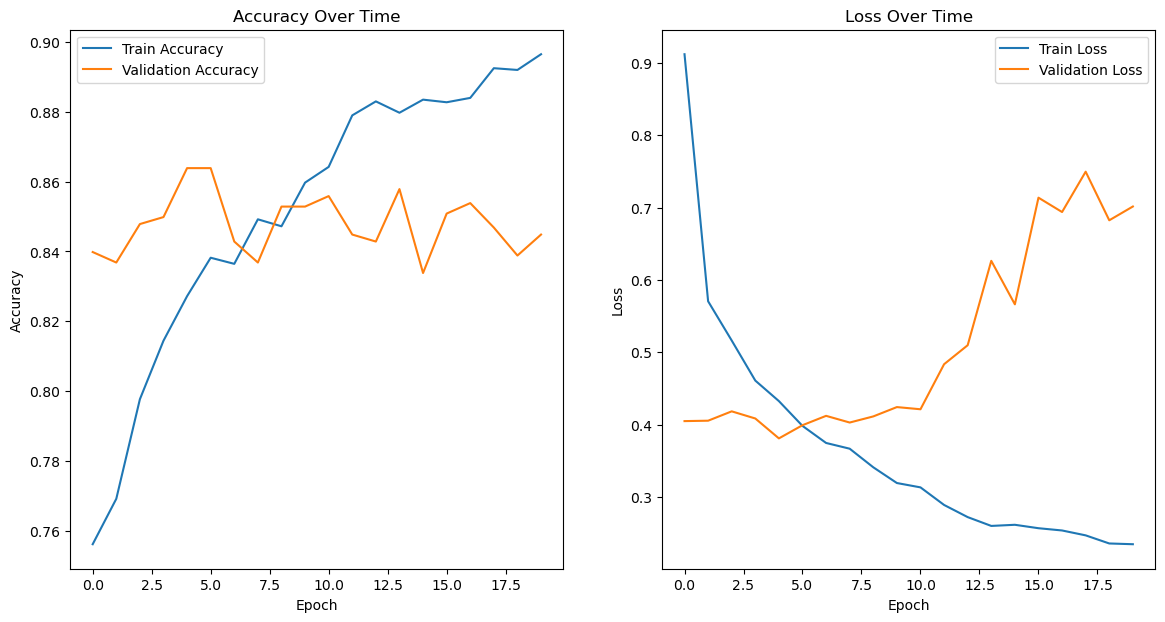

In [157]:

X = np.array(X_train)  
y = np.array(y_train)  

# Initialize variables to store results
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
accuracy_per_fold = []
loss_per_fold = []

# Define function to create the model
def create_model(input_shape):
    model = Sequential([
        Dense(1000, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'), 
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation loop
fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    # Split data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Standardize the data ###### DELETE THIS 
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Create and train the model
    model = create_model(X_train_fold.shape[1])
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, batch_size=32, verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

# Plot the results
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

# Training history plotting for the last fold (as an example)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.show()


In [163]:
print("X_train_reduced shape:", X_train.shape) 
print("X_val_reduced shape:", X_val.shape) 

X_train_reduced shape: (4998, 3600)
X_val_reduced shape: (1250, 3600)


In [ ]:
# We will try the same and see if merging the 10 comments into one will improve the model or not 

In [164]:
def average_and_reduce(row, num_features=12, embedding_size=300, num_comments=10):
    # Reshape the row to separate the embeddings
    embeddings = row.reshape((num_features, embedding_size))
    # Average the last 10 comment embeddings
    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)
    # Concatenate the first 2 embeddings with the averaged comments
    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

# Apply the function to each row in X_train and X_val
X_train = np.apply_along_axis(average_and_reduce, 1, X_train)
X_val = np.apply_along_axis(average_and_reduce, 1, X_val)

# Verify the shapes
print("X_train_reduced shape:", X_train.shape)  # Should be (4998, 2304)
print("X_val_reduced shape:", X_val.shape) 

X_train_reduced shape: (4998, 900)
X_val_reduced shape: (1250, 900)


In [165]:
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the average accuracy across all folds
print("Average cross-validation score: ", np.mean(scores))

knn.fit(X_train, y_train)

val_predictions = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Average cross-validation score:  0.8501395395395395
Validation accuracy:  0.86


Training fold 1...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7588 - loss: 0.4762 - val_accuracy: 0.8690 - val_loss: 0.3641
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8331 - loss: 0.4128 - val_accuracy: 0.8690 - val_loss: 0.3544
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8597 - loss: 0.3787 - val_accuracy: 0.8800 - val_loss: 0.3475
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8581 - loss: 0.3812 - val_accuracy: 0.8780 - val_loss: 0.3386
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8704 - loss: 0.3633 - val_accuracy: 0.8820 - val_loss: 0.3376
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8742 - loss: 0.3496 - val_accuracy: 0.8840 - val_loss: 0.3389
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8837 - loss: 0.3196 - val_accuracy: 0.8820 - val_loss: 0.3447
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8703 - loss: 0.355

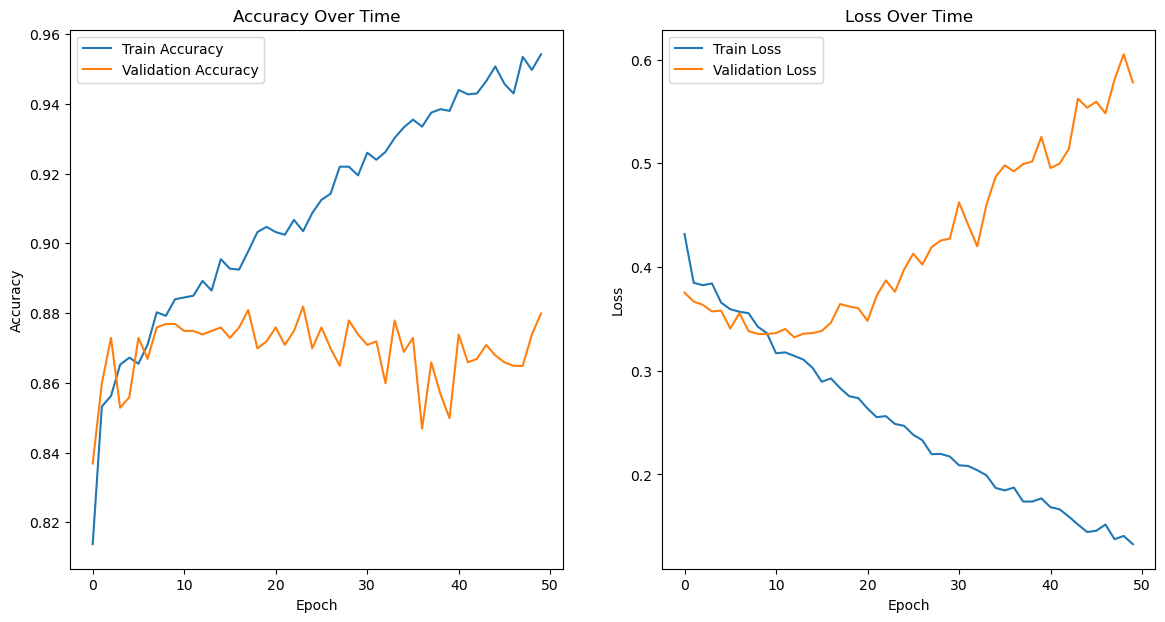

In [167]:
X = np.array(X_train) 
y = np.array(y_train)  

# Cross-validation loop
fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    # Split data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Create and train the model
    model = create_model(X_train_fold.shape[1])
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=32, verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

# Plot the results
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

# Training history plotting for the last fold (as an example)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.show()

## 3.3 We will now try TF-IDF with the translated

In [297]:
# import /Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv 
df_train = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv")


In [298]:
df_train = df_train.applymap(clean_text)

/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_79552/3137519247.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train = df_train.applymap(clean_text)
/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_79552/920284052.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [299]:
df_train 

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,shared mixed room hostel shared bathroom locat...,local accommodation registration al,nice,top,cozy place good place stay clean organized eve...,property absolutely clean stylish exactly show...,everything correct like photo said important k...,pleasant people attentive well thank able plea...,,stay corona outbreak starting still well recei...,great location good communication,beside big street park find door car shop near...
1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,charming apartment chiado largo carmo travessa...,hellox portuguese love meet people around word...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...,fabulous view nice apartment fantastic locatio...,nice view clean great location,lovely apartment great view beach apartment fu...,spectacular location awsome place,boyfriend stayed sonia week august sonia perfe...,clean appartement nice oceanview highly recomm...,everything correct house perfect clean view be...,clean calm place perfect location beach grocer...,great stay apartment compliant comfortable qui...,really enjoyed staying sonias place apartment ...
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,studio new well decorated cozy apartment great...,im brand manager lisbon portugal grew macau so...,superb studio clean super well equipped locati...,really enjoyed stay host location apartment am...,perfectly adapted well equipped accommodation ...,vasco wife wonderful people missed bus check l...,vasco always responded quickly gave u lot tip ...,great time vascos appartment everything descri...,host super supportive nice guy gave tip made s...,parent great stay studio lisbon vasco gave bes...,vasco anna amazing host picked u train station...,excellent host kind fast friendly central
6244,lisbon meet cosmopolitan industrial one bedroo...,home feeling visitor let comfort reflect big p...,spacious apartment heart barrio alto plenty ro...,place great modern clean flat right heart want...,air conditioning would welcome location great,careful little cold winter great view room nei...,apartment well located well isolated street no...,good stay bairro alto apartment comfortable id...,awesome host perfect communication nice flat o...,apartment nice enjoyed,great place stay lisbon day check easy clean p...,really good time flat x host well organized fl...
6245,license numberexempt,travel agent passionate culture welcome guest ...,location location location beach vibe looonggg...,apartment pleasant mentioned advertisement clo...,recommend host extremely hard communicate woul...,best stay estoril sara great host nice cool po...,excellent stay saras everything thoroughly det...,good location sara attentive time,spent two day estoril stormy coast weather com...,saras place described even though small comfor...,location back appears small village house adve...,sara great host always attentive everything wo...
6246,campo pequeno prestige classy top quality apar...,familyx portugalx gaviox musicx tour,enjoy stay due problem treated u well,comfortable easy stay four night shared apartm...,maria amazing host entire place cozy nice real...,nice spacious room near entrecompose train sta...,another great stay second maria convenient cle...,clean great location great shopping comfortable,great place close two subway station bakery ma...,excellent stay impeccable facility attentive h...,good time apartment share kitchen two bathroom...,close metro place clean tidy room spacious


In [300]:
df_train = pd.concat([df_train, df_train_copy['unlisted']], axis=1)


In [301]:
df_train

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,shared mixed room hostel shared bathroom locat...,local accommodation registration al,nice,top,cozy place good place stay clean organized eve...,property absolutely clean stylish exactly show...,everything correct like photo said important k...,pleasant people attentive well thank able plea...,,stay corona outbreak starting still well recei...,great location good communication,beside big street park find door car shop near...,0
1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,charming apartment chiado largo carmo travessa...,hellox portuguese love meet people around word...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...,fabulous view nice apartment fantastic locatio...,nice view clean great location,lovely apartment great view beach apartment fu...,spectacular location awsome place,boyfriend stayed sonia week august sonia perfe...,clean appartement nice oceanview highly recomm...,everything correct house perfect clean view be...,clean calm place perfect location beach grocer...,great stay apartment compliant comfortable qui...,really enjoyed staying sonias place apartment ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,studio new well decorated cozy apartment great...,im brand manager lisbon portugal grew macau so...,superb studio clean super well equipped locati...,really enjoyed stay host location apartment am...,perfectly adapted well equipped accommodation ...,vasco wife wonderful people missed bus check l...,vasco always responded quickly gave u lot tip ...,great time vascos appartment everything descri...,host super supportive nice guy gave tip made s...,parent great stay studio lisbon vasco gave bes...,vasco anna amazing host picked u train station...,excellent host kind fast friendly central,0
6244,lisbon meet cosmopolitan industrial one bedroo...,home feeling visitor let comfort reflect big p...,spacious apartment heart barrio alto plenty ro...,place great modern clean flat right heart want...,air conditioning would welcome location great,careful little cold winter great view room nei...,apartment well located well isolated street no...,good stay bairro alto apartment comfortable id...,awesome host perfect communication nice flat o...,apartment nice enjoyed,great place stay lisbon day check easy clean p...,really good time flat x host well organized fl...,0
6245,license numberexempt,travel agent passionate culture welcome guest ...,location location location beach vibe looonggg...,apartment pleasant mentioned advertisement clo...,recommend host extremely hard communicate woul...,best stay estoril sara great host nice cool po...,excellent stay saras everything thoroughly det...,good location sara attentive time,spent two day estoril stormy coast weather com...,saras place described even though small comfor...,location back appears small village house adve...,sara great host always attentive everything wo...,1
6246,campo pequeno prestige classy top quality apar...,familyx portugalx gaviox musicx tour,enjoy stay due problem treated u well,comfortable easy stay four night shared apartm...,maria amazing host entire place cozy nice real...,nice spacious room near entrecompose train sta...,another great stay second maria convenient cle...,clean great location great shopping comfortable,great place close two subway station bakery ma...,excellent stay impeccable facility attentive h...,good time apartment share kitchen two bathroom...,close metro place clean tidy room spacious,0


In [302]:
df = df_train.copy()

In [303]:
text_columns = [
    'description', 'host_about', 'comment 1', 'comment 2', 'comment 3', 'comment 4', 
    'comment 5', 'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10'
]
df['combined_text'] = df[text_columns].fillna('').agg(' '.join, axis=1)




In [304]:
X = df['combined_text']
y = df['unlisted']


In [305]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [306]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000000, stop_words='english')


In [307]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)


In [308]:
print(X_train.shape)  
print(X_val.shape)  


(4998, 26681)
(1250, 26681)


In [309]:
# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8632


In [310]:
cm = confusion_matrix(y_val, y_pred)


In [311]:
print(cm)

[[819  86]
 [ 85 260]]


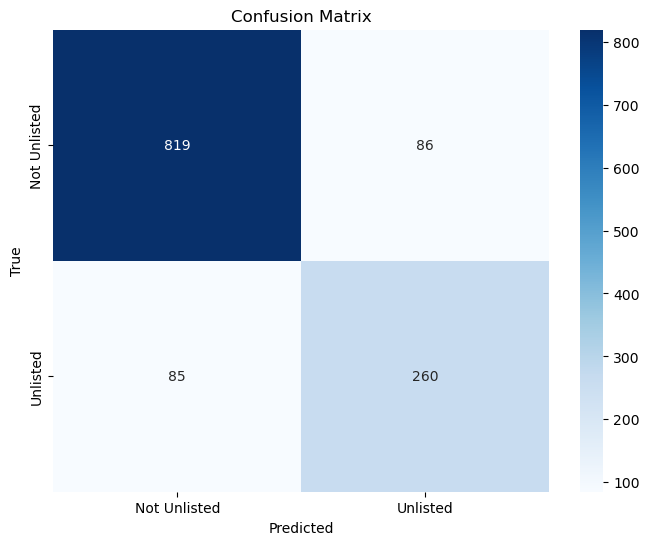

In [312]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Unlisted', 'Unlisted'], yticklabels=['Not Unlisted', 'Unlisted'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [313]:
rf = RandomForestClassifier(random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Average cross-validation score on training data: ", np.mean(cv_scores))

# Train the model on the full training set
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Average cross-validation score on training data:  0.8719491491491491
Validation accuracy:  0.8824


In [314]:
# Define the model with some chosen hyperparameters
knn = KNeighborsClassifier(n_neighbors=5)

# Perform 5-fold cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the average accuracy across all folds
print("Average cross-validation score: ", np.mean(scores))

knn.fit(X_train, y_train)

val_predictions = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)


Average cross-validation score:  0.8029221221221222
Validation accuracy:  0.8272


In [ ]:
# Won't be using NN here because it doesnt do well with the spare data

## 3.4 - Using GLOVE instead of word2vec but all will be the same 


In [326]:
#import df 
df = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv")

In [327]:
df = df.applymap(clean_text)

/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_79552/2197956661.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_text)
/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_79552/1433993042.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [328]:
df = pd.concat([df, df_train_copy['unlisted']], axis=1)
#replace nan with empty string
df = df.fillna('')
df['unlisted'] = df['unlisted'].astype(int)


In [331]:

glove = api.load('glove-wiki-gigaword-300')

emb_size = 300

# Function to get embeddings for each word based on GloVe model
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        # Ensure the document is a string
        if not isinstance(document, str):
            document = ''
        # Get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in glove.key_to_index:
                doc_vectors.append(glove.get_vector(word))
        corpus_vec.append(doc_vectors)
    return corpus_vec

def df_corpus2vec(df, exclude_columns=[]):
    df_vec = pd.DataFrame(index=df.index, columns=df.columns)
    for col in df.columns:
        if col not in exclude_columns:
            # Ensure all entries are strings and fill NaN values
            df[col] = df[col].fillna('').astype(str)
            df_vec[col] = corpus2vec(df[col].tolist())
        else:
            df_vec[col] = df[col]
    return df_vec

# Apply the function to the DataFrame, excluding the "unlisted" column
df_glove_vec = df_corpus2vec(df, exclude_columns=['unlisted'])

# Save the DataFrame to a pickle file
df_glove_vec.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_glove_vec.pkl")


  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

In [332]:
df_glove_vec

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.39364, 0.44549, 0.095354, -0.56394, -0.08...","[[-0.34413, 0.37822, 0.35644, -0.062996, 0.290...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[0.13874, 0.70128, -0.053805, -0.40267, -0.00...","[[-0.29934, 0.30112, -0.28977, -0.1366, -0.416...","[[0.19596, 0.13208, -0.30807, 0.25545, -0.1265...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[-1.0572, -0.56766, 0.068961, -0.16285, -0.29...",[],"[[0.11001, -0.065944, -0.36711, 0.30169, 0.376...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[-0.31801, 0.20879, -0.035642, -0.16209, -0.4...",0
1,"[[0.25443, -0.22324, 0.012081, -0.49354, -0.16...","[[-0.38923, 0.32972, -0.097624, -0.57717, 0.05...",[],[],[],[],[],[],[],[],[],[],1
2,"[[-0.3707, -0.081209, -0.44626, 0.097395, 0.19...","[[-0.67916, -0.12207, -0.22908, 0.34682, 0.308...",[],[],[],[],[],[],[],[],[],[],1
3,"[[-0.11905, -0.39071, 0.076198, -0.42436, 0.24...","[[-0.019703, -0.068198, -0.52512, 0.49465, 0.4...",[],[],[],[],[],[],[],[],[],[],0
4,"[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.38547, 0.59784, 0.16526, -0.28517, 0.3189...","[[0.29731, 0.13388, 0.043151, 0.25688, 0.3564,...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.63411, -0.50571, -0.36741, -0.12871, -0.2...","[[0.62462, 0.29682, 0.11151, -0.039201, -0.055...","[[-0.39638, 0.017982, -0.13137, 0.098925, 0.06...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[0.076563, 0.032454, -0.030982, -0.018969, 0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[[-0.013853, 0.24197, -0.60333, 0.095657, -0.1...","[[0.17876, -0.56186, 0.048086, -0.65694, 0.094...","[[0.5812, 0.38176, -0.11973, 0.091912, 0.3154,...","[[0.076563, 0.032454, -0.030982, -0.018969, 0....","[[-0.65682, 0.11616, 0.057143, 0.1139, -0.2229...","[[-0.14963, 0.18107, -0.25735, 0.10486, 0.0671...","[[-0.14963, 0.18107, -0.25735, 0.10486, 0.0671...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[-0.15685, 0.6209, 0.0083847, -0.067834, 0.13...","[[0.022868, -0.11961, 0.030742, 0.2205, -0.014...","[[-0.14963, 0.18107, -0.25735, 0.10486, 0.0671...","[[0.3033, 0.17964, 0.19224, -0.18644, 0.013153...",0
6244,"[[-0.031203, -0.30432, -0.54618, 0.40214, 0.65...","[[-0.1983, 0.40716, -0.35536, 0.21121, -0.0589...","[[-0.19882, -0.17232, -0.44029, -0.24909, -0.0...","[[0.080622, 0.13208, -0.0047645, -0.45613, -0....","[[0.3094, 0.073576, -0.0054402, -0.46208, -0.0...","[[0.19551, -0.2407, 0.36401, 0.066503, 0.13797...","[[-0.47123, 0.38333, -0.68614, -0.29108, 0.206...","[[-0.13602, -0.11594, -0.017078, -0.29256, 0.0...","[[0.097666, 0.13236, 0.027085, 0.24798, -0.125...","[[-0.47123, 0.38333, -0.68614, -0.29108, 0.206...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[0.076563, 0.032454, -0.030982, -0.018969, 0....",0
6245,"[[-0.03448, -0.39403, -0.25887, -0.13507, -0.4...","[[0.15453, -0.38784, -0.29492, 0.041385, 0.421...","[[-0.66892, -0.16926, -0.14479, -0.23504, -0.1...","[[-0.47123, 0.38333, -0.68614, -0.29108, 0.206...","[[0.11414, 0.14695, -0.032102, -0.014017, 0.14...","[[0.089135, 0.71792, 0.028687, 0.21612, 0.0341...","[[0.3033, 0.17964, 0.19224, -0.18644, 0.013153...","[[-0.13602, -0.11594, -0.017078, -0.29256, 0.0...","[[-0.32986, 0.025145, -0.14014, 0.23611, -0.03...","[[0.71944, -0.11852, -0.32135, 0.15169, -0.125...","[[-0.66892, -0.16926, -0.14479, -0.23504, -0.1...","[[-0.053819, 0.27431, -0.30908, 0.18892, -0.01...",1
6246,"[[-0.086108, 0.88159, -0.45484, 0.09496, 0.113...","[[-0.14823, -0.0035051, -0.30723, -0.27534, 0....","[[-0.15158, -0.14309, 0.027486, -0.015751, -0....","[[-0.095026, 0.0015429, 0.29445, -0.01734, -0....","[[-0.42667, 0.041012, -0.68039, -0.24334, 0.10...","[[-0.23945, 0.12185, -0.23636,

In [333]:
df_glove_vec = df_glove_vec.apply(fill_empty_cells, axis=1)



In [334]:
df_glove_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.39364, 0.44549, 0.095354, -0.56394, -0.08...","[[-0.34413, 0.37822, 0.35644, -0.062996, 0.290...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[0.13874, 0.70128, -0.053805, -0.40267, -0.00...","[[-0.29934, 0.30112, -0.28977, -0.1366, -0.416...","[[0.19596, 0.13208, -0.30807, 0.25545, -0.1265...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[-1.0572, -0.56766, 0.068961, -0.16285, -0.29...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.11001, -0.065944, -0.36711, 0.30169, 0.376...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[-0.31801, 0.20879, -0.035642, -0.16209, -0.4...",0
1,"[[0.25443, -0.22324, 0.012081, -0.49354, -0.16...","[[-0.38923, 0.32972, -0.097624, -0.57717, 0.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[[-0.3707, -0.081209, -0.44626, 0.097395, 0.19...","[[-0.67916, -0.12207, -0.22908, 0.34682, 0.308...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[[-0.11905, -0.39071, 0.076198, -0.42436, 0.24...","[[-0.019703, -0.068198, -0.52512, 0.49465, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.38547, 0.59784, 0.16526, -0.28517, 0.3189...","[[0.29731, 0.13388, 0.043151, 0.25688, 0.3564,...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.63411, -0.50571, -0.36741, -0.12871, -0.2...","[[0.62462, 0.29682, 0.11151, -0.039201, -0.055...","[[-0.39638, 0.017982, -0.13137, 0.098925, 0.06...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[0.076563, 0.032454, -0.030982, -0.018969, 0....",0


In [336]:
for col in df_glove_vec.columns:
    if col != 'unlisted':
        df_glove_vec[col] = df_glove_vec[col].apply(average_vector_list)

In [338]:
df_glove_vec = df_glove_vec.apply(replace_zero_vector, axis=1)


In [339]:
df_train, df_val = train_test_split(df_glove_vec, test_size=0.2, random_state=42)

In [341]:
X_train = df_train[['description', 'host_about', 
                    'comment 1', 'comment 2', 'comment 3', 
                    'comment 4', 'comment 5', 'comment 6', 
                    'comment 7', 'comment 8', 'comment 9', 
                    'comment 10']]
X_val = df_val[['description', 'host_about',
                'comment 1', 'comment 2', 'comment 3', 
                'comment 4', 'comment 5', 'comment 6', 
                'comment 7', 'comment 8', 'comment 9', 
                'comment 10']]

y_train = df_train['unlisted']
y_val = df_val['unlisted']

In [342]:
X_train_flattened = X_train.apply(flatten_row, axis=1)
X_val_flattened = X_val.apply(flatten_row, axis=1)
X_train = np.vstack(X_train_flattened.values)
X_val = np.vstack(X_val_flattened.values)
y_val = y_val.astype(int)
y_train = y_train.astype(int)

In [343]:
rf = RandomForestClassifier(random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Average cross-validation score on training data: ", np.mean(cv_scores))

# Train the model on the full training set
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Average cross-validation score on training data:  0.8883569569569569
Validation accuracy:  0.8952


In [344]:
# Define the model with some chosen hyperparameters
knn = KNeighborsClassifier(n_neighbors=5)

# Perform 5-fold cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the average accuracy across all folds
print("Average cross-validation score: ", np.mean(scores))

knn.fit(X_train, y_train)

val_predictions = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Average cross-validation score:  0.8661481481481481
Validation accuracy:  0.8688


Training fold 1...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6912 - loss: 0.8956 - val_accuracy: 0.8660 - val_loss: 0.3772
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7898 - loss: 0.4906 - val_accuracy: 0.8700 - val_loss: 0.3745
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7944 - loss: 0.4802 - val_accuracy: 0.8600 - val_loss: 0.3865
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7890 - loss: 0.4183 - val_accuracy: 0.8720 - val_loss: 0.3723
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8092 - loss: 0.4011 - val_accuracy: 0.8750 - val_loss: 0.3783
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8405 - loss: 0.3487 - val_accuracy: 0.8690 - val_loss: 0.3801
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8552 - loss: 0.3389 - val_accuracy: 0.8710 - val_loss: 0.3952
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8571 - loss: 0.3453 - val_accu

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7283 - loss: 0.9181 - val_accuracy: 0.8560 - val_loss: 0.3935
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7886 - loss: 0.5145 - val_accuracy: 0.8450 - val_loss: 0.4024
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7604 - loss: 0.5320 - val_accuracy: 0.8570 - val_loss: 0.3981
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8324 - loss: 0.4659 - val_accuracy: 0.8550 - val_loss: 0.4370
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8448 - loss: 0.4052 - val_accuracy: 0.8470 - val_loss: 0.3981
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8468 - loss: 0.3853 - val_accuracy: 0.8570 - val_loss: 0.3945
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8327 - loss: 0.4061 - val_accuracy: 0.8610 - val_loss: 0.3977
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8635 - loss: 0.3286 - val_accu

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7526 - loss: 0.8019 - val_accuracy: 0.8300 - val_loss: 0.4017
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8078 - loss: 0.4524 - val_accuracy: 0.8420 - val_loss: 0.4153
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8309 - loss: 0.4309 - val_accuracy: 0.8060 - val_loss: 0.4050
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8140 - loss: 0.4321 - val_accuracy: 0.8440 - val_loss: 0.3957
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8568 - loss: 0.3878 - val_accuracy: 0.8490 - val_loss: 0.4008
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8591 - loss: 0.3950 - val_accuracy: 0.8470 - val_loss: 0.4092
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8611 - loss: 0.3634 - val_accuracy: 0.8420 - val_loss: 0.4263
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8672 - loss: 0.3200 - val_accu

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7487 - loss: 0.8957 - val_accuracy: 0.7477 - val_loss: 0.3929
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7706 - loss: 0.5099 - val_accuracy: 0.8679 - val_loss: 0.4037
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8241 - loss: 0.5009 - val_accuracy: 0.8699 - val_loss: 0.3995
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8248 - loss: 0.4526 - val_accuracy: 0.8629 - val_loss: 0.3811
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8360 - loss: 0.4191 - val_accuracy: 0.8669 - val_loss: 0.3853
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8449 - loss: 0.4016 - val_accuracy: 0.8719 - val_loss: 0.3789
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8549 - loss: 0.3569 - val_accuracy: 0.8719 - val_loss: 0.3966
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8408 - loss: 0.3497 - val_accu

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7409 - loss: 0.8386 - val_accuracy: 0.8529 - val_loss: 0.3937
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7703 - loss: 0.5560 - val_accuracy: 0.7267 - val_loss: 0.4213
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7811 - loss: 0.4820 - val_accuracy: 0.7978 - val_loss: 0.4056
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7597 - loss: 0.4472 - val_accuracy: 0.8589 - val_loss: 0.3978
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8315 - loss: 0.3995 - val_accuracy: 0.8639 - val_loss: 0.3940
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8479 - loss: 0.3629 - val_accuracy: 0.8488 - val_loss: 0.4268
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8611 - loss: 0.3279 - val_accuracy: 0.8468 - val_loss: 0.4225
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8741 - loss: 0.3063 - val_accu

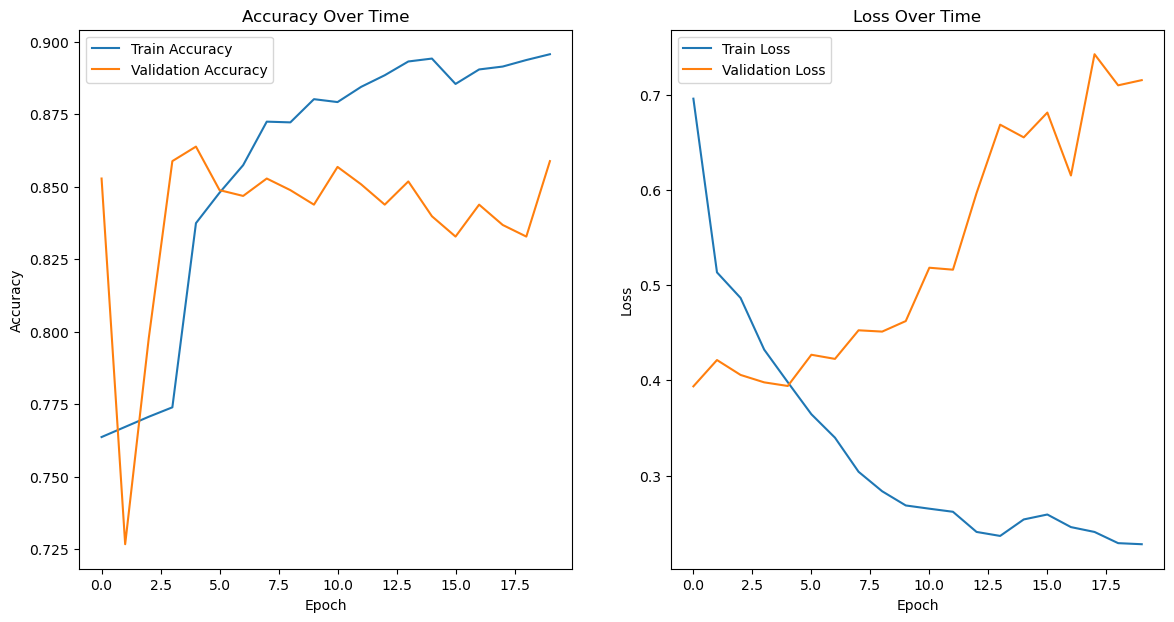

In [345]:
X = np.array(X_train)  
y = np.array(y_train)  

# Initialize variables to store results
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
accuracy_per_fold = []
loss_per_fold = []

# Define function to create the model
def create_model(input_shape):
    model = Sequential([
        Dense(1000, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'), 
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation loop
fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    # Split data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Standardize the data ###### DELETE THIS 
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Create and train the model
    model = create_model(X_train_fold.shape[1])
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, batch_size=32, verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

# Plot the results
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

# Training history plotting for the last fold (as an example)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.show()

# final conclusion 

In [356]:
# the model that perfomed better was the embedding with BERT and using an average of the comments and rf. 



In [3]:
#import the embeddings
X_train = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
X_val = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")


In [28]:
#getting the target variable
y = df_train_copy.copy()

In [29]:
y = y['unlisted']

In [30]:
y_train, y_val = train_test_split(y, test_size=0.2, random_state=42)

In [33]:

X_train_flattened = X_train.apply(flatten_row, axis=1)
X_val_flattened = X_val.apply(flatten_row, axis=1)

X_train = np.vstack(X_train_flattened.values)
X_val = np.vstack(X_val_flattened.values)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [34]:
def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

In [35]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train)
X_val = np.apply_along_axis(average_and_reduce, 1, X_val)

print("X_train_reduced shape:", X_train.shape) 
print("X_val_reduced shape:", X_val.shape) 



X_train_reduced shape: (4998, 2304)
X_val_reduced shape: (1250, 2304)


In [38]:
param_grid = {
    'n_estimators': [100, 200],
    'class_weight': [None, 'balanced'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2], 
    'max_depth': [10, 20]
}

rf = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Train the model with the best parameters on the full training set
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = best_rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.8s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.9s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.9s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  30.1s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  52.6s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  52.8s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=20

In [39]:
#lets import the test data /Users/diogoparreira/Downloads/Project Corpora/test_reviews.xlsx
df_test = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/test.xlsx")

#and test reviews 
df_test_reviews = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/test_reviews.xlsx")




In [40]:
df_test_reviews_10 = df_test_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)
max_index_test = df_test_reviews["index"].max()
df_sampled_test = ensure_ten_comments_per_index(df_test_reviews_10, max_index_test)
df_pivoted_test = pivot_comments(df_sampled_test)
df_test = pd.merge(df_test, df_pivoted_test, on='index', how='left')
df_test.head()

,index,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Das Apartment ist großartig! Tolle Lage und ex...,The taxi had a bit troubles to find the apartm...,Wow we had a great time in Lisbon! And the ex...,"The flat did not meet our expectations, there ...",This is a spacious flat in a quiet residential...,"Big and well located ground floor apartment, a...",I have stayed at this property multiple times ...,"Le logement est confortable, bien équipé, bien...",We liked the place for it’t location. Close to...,Our host Antonio was very helpful with informa...
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"Appartement très agréable, lumineux, propre.<b...","This is a beautiful, bright apartment in a mor...",A great place to stay,"Very close to city center, can sleep 5 people....","We'd a very pleasant stay, the apartment was a...",El departamento es tal cual aparece en las fot...,"Due to a late check out, the cleaning ladies d...","A casa é incrível, ideal para familia e ou gru...",We had a really nice stay. Everything was as e...,Flat was clean and well maintained with nice t...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",,,,,,,,,,
3,4,Charming Apartment Close to the Bay of Cascais...,:),Claudia was a great host. She met us at the t...,"This aptartment was great , fabulous location ...",Apartamento situado en una inmejorable zona de...,Casio do Castelo lll is a lovely apartment wit...,Great location!,La posición del apartamento no puede ser mejor...,Super appartement très bien situé à deux pas d...,Comfortable apartment. Easy check-in. Perfec...,This is an absolutely beautiful little apartme...,"The apartment is very well located, clean and ..."
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,Nous avons passé un très bon sejour dans cet a...,A lovely space and Helena is a really nice hos...,"Bel appartement, très bien décoré et agencé. T...",Thanks Helena for a comfortable place. We had ...,"ottimo soggiorno, casa piccola ma accogliente ...",Perfect location to visit Lisbon and surroundi...,"For two adults and two children it’s ok, small...",Très belle petite maison dans un endroit calme...,"Really great hosts, really nice and always nic...",Le logement est conforme aux photos et à la de...


In [43]:
#do the same for test
# Embed all descriptions
descriptions = df_test['description'].astype(str).tolist()
description_embeddings = []

# Embed descriptions with progress bar
for desc in tqdm(descriptions, desc="Embedding descriptions"):
    description_embeddings.append(get_distilbert_embedding(desc))

df_test['description_embedding'] = description_embeddings

# Get host abouts and convert to list of strings
host_abouts = df_test['host_about'].astype(str).tolist()

# Embed host abouts with progress bar
host_about_embeddings = []
for host_about in tqdm(host_abouts, desc="Embedding host abouts"):
    host_about_embeddings.append(get_distilbert_embedding(host_about))

# Assign host about embeddings to DataFrame
df_test['host_about_embedding'] = host_about_embeddings

# Embed all comments
comments_columns = ['comment 1', 'comment 2', 'comment 3', 'comment 4', 'comment 5', 
                    'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

# Initialize a dictionary to hold embeddings for each comment column
comments_embeddings = {col: [] for col in comments_columns}

# Embed each comment column separately with progress bar
for col in comments_columns:
    comments = df_test[col].tolist()
    for comment in tqdm(comments, desc=f"Embedding {col}"):
        if isinstance(comment, str):
            comments_embeddings[col].append(get_distilbert_embedding(comment))
        else:
            # Use a zero vector if the comment is not a string (e.g., NaN)
            comments_embeddings[col].append(np.zeros(768))

# Add embeddings back to the dataframe
for col in comments_columns:
    df_test[f'{col}_embedding'] = comments_embeddings[col]

Embedding descriptions:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding host abouts:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 1:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 2:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 3:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 4:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 5:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 6:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 7:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 8:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 9:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 10:   0%|          | 0/695 [00:00<?, ?it/s]

In [44]:
# lets merge the train and val data
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])


In [47]:

#train the rf with the best parameters and with all of the training data and val data to produce the predictions for the test data
best_rf.fit(X_train_val, y_train_val)

# Get the embeddings for the test data
X_test = df_test[['description_embedding', 'host_about_embedding', 
                  'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                  'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                  'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                  'comment 10_embedding']]




In [49]:
X_test_flattened = X_test.apply(flatten_row, axis=1)
X_test = np.vstack(X_test_flattened.values)

def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

X_test = np.apply_along_axis(average_and_reduce, 1, X_test)

# Predict on the test data
test_predictions = best_rf.predict(X_test)

# Save the predictions to a CSV file
output_file_path = "/Users/diogoparreira/Downloads/Project Corpora/test_predictions.csv"

In [50]:
test_predictions

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0.